In [ ]:
import matplotlib
import networkx as nx
import json
import numpy as np
import random
import scipy.special
import sys
import json
import pickle 
import argparse
import matplotlib.pyplot as plt

from itertools import combinations
from tqdm import tqdm, trange
import sys

import re
import ast

In [ ]:
f = open("../data_collection/data/data.json", "r")

In [ ]:
t3_list = list(json.load(f).keys())

In [ ]:
t3_map = json.load(f)

In [ ]:
def get_component_by_t3(G, t3):
    results = []
    t3_item = t3_map[t3]
    if t3_item["author"]["id"] in G.nodes():
      results.append(t3_item["author"]["id"])
    for t1 in t3_item["comments"]:
      if t3_item["comments"][t1]["author"]["id"] in G.nodes():
        results.append(t3_item["comments"][t1]["author"]["id"])
    return results

In [ ]:
# Load the graph
print('Reading the graph...')
G = nx.read_gexf('/content/drive/MyDrive/SNA/data_collection/GS.gexf')
print('Graph read.')

Reading the graph...
Graph read.


In [ ]:
from tqdm import tqdm

t3_components = {}
for t3 in tqdm(t3_list):
    t3_components[t3] = get_component_by_t3(G, t3)

100%|██████████| 38706/38706 [00:03<00:00, 12572.59it/s]


In [ ]:
import ast
t3_components_with_toxic_comment = {}
t3_with_toxic_comment = set()
t3_occurences_toxic = {}
for (u, v) in tqdm(G.edges()):
    comments = ast.literal_eval(G.edges[u, v]["comments"])
    for t1 in comments.keys():
      comment = comments[t1]
      if 'labels' in comment:
        if float(comment['labels']['political_leaning']['pol_score']) > 0.5:
          t3_with_toxic_comment.add(comment['link_id'])
          if not comment['link_id'] in t3_occurences_toxic:
            t3_occurences_toxic[comment['link_id']] = 1
          else:
            t3_occurences_toxic[comment['link_id']] += 1

100%|██████████| 505118/505118 [01:30<00:00, 5577.69it/s]


In [ ]:
for t3 in tqdm(t3_with_toxic_comment):
  t3_components_with_toxic_comment[t3] = t3_components[t3]

100%|██████████| 27656/27656 [00:00<00:00, 734836.85it/s]


In [ ]:
def build_hist(components):
    sizes_counter = {}
    sizes = [len(components[component]) for component in components]
    for size in sizes:
        if not size in sizes_counter:
            sizes_counter[size] = 0
        sizes_counter[size] += 1
    sorted_keys = sorted(sizes_counter.keys())
    fig = plt.figure(figsize=(50, 10))
    plt.grid()
    plt.yscale('log')
    plt.scatter(x=[str(v) for v in sorted_keys], y=[sizes_counter[v] for v in sorted_keys]) 
    plt.plot([str(v) for v in sorted_keys], [sizes_counter[v] for v in sorted_keys]) 
    plt.ylabel('#Components')
    plt.xlabel('#Nodes')
    return fig, sizes_counter

In [ ]:
for t3 in t3_list:
  if not t3 in t3_occurences_toxic:
    t3_occurences_toxic[t3] = 0

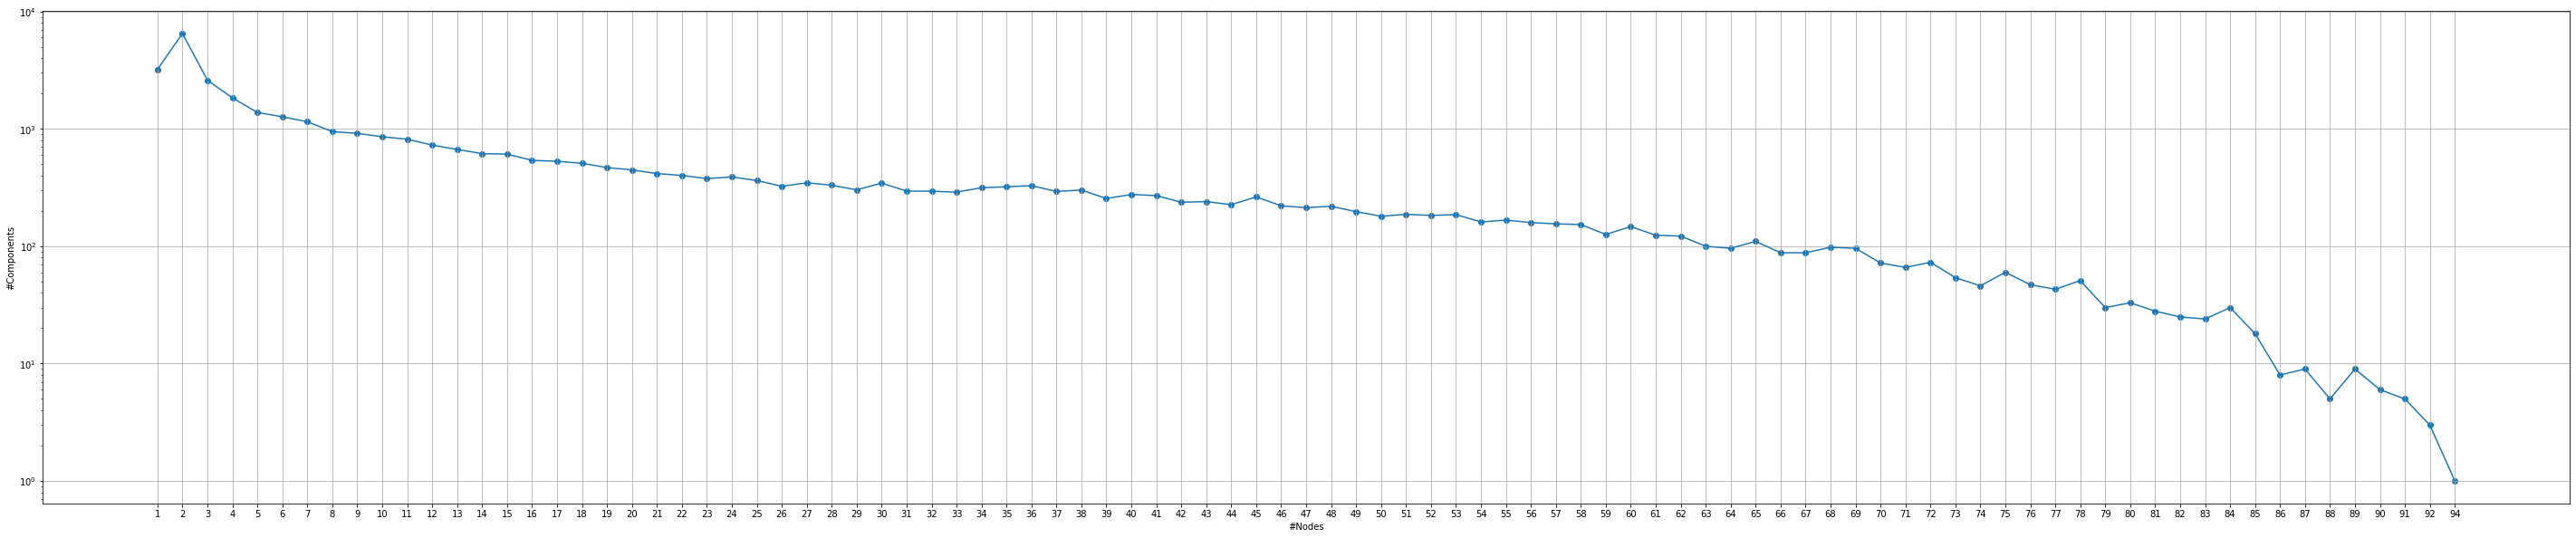

In [ ]:
fig, size_counter = build_hist(t3_components)

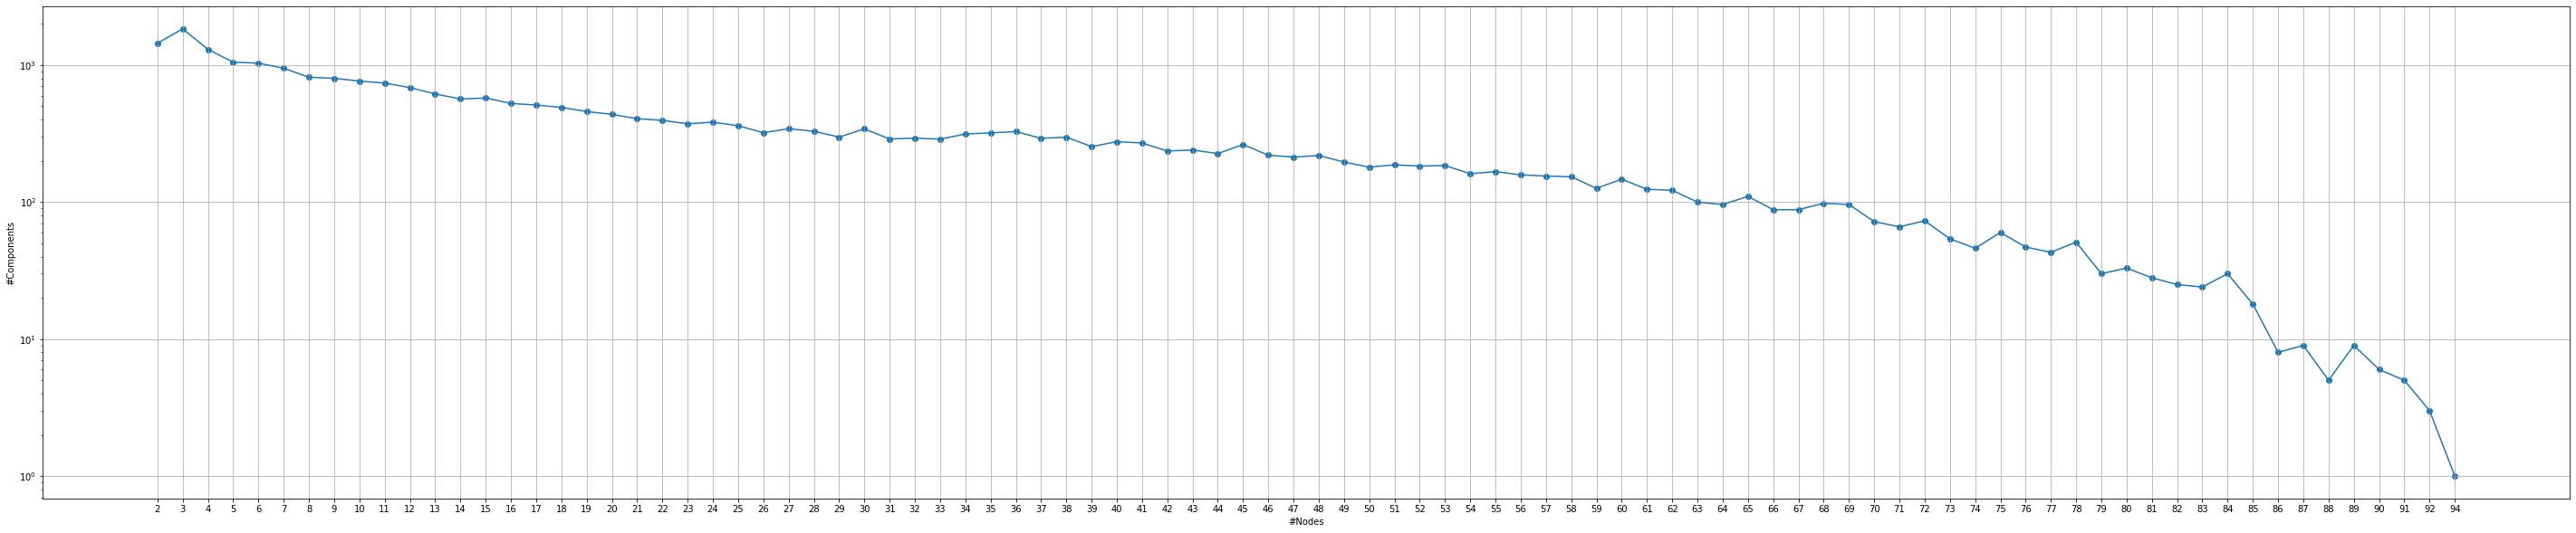

In [ ]:
fig, size_counter = build_hist(t3_components_with_toxic_comment)

In [ ]:
import collections
dx = collections.OrderedDict(sorted(t3_components.items()))
dy = collections.OrderedDict(sorted(t3_occurences_toxic.items()))
num_users = [len(dx[val]) for val in dx]
num_toxic = [dy[val] for val in dy]

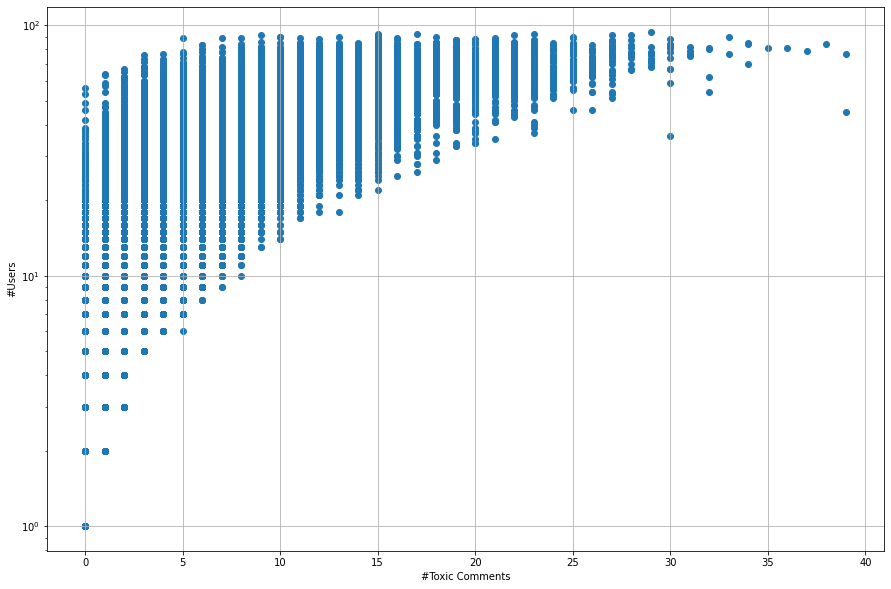

In [ ]:
fig = plt.figure(figsize=(15, 10))
plt.grid()
plt.yscale('log')
plt.scatter(x=num_toxic, y=num_users) 
plt.ylabel('#Users')
plt.xlabel('#Toxic Comments')

In [ ]:
import statistics
avg_users = {}
for value in dy:
  if not dy[value] in avg_users:
    avg_users[dy[value]] = []
  avg_users[dy[value]].append(len(dx[value]))
for value in avg_users:
  avg_users[value] = statistics.mean(avg_users[value])

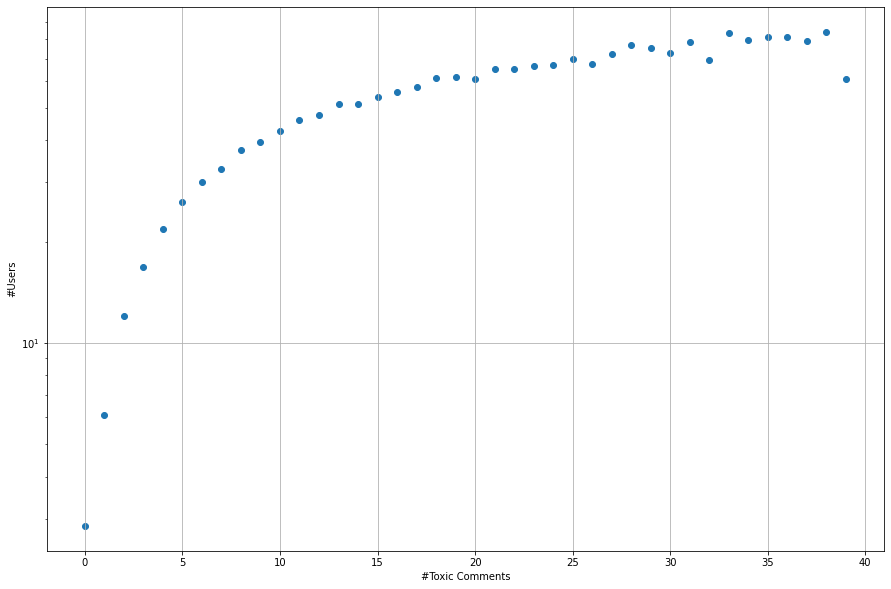

In [ ]:
fig = plt.figure(figsize=(15, 10))
plt.grid()
plt.yscale('log')
plt.scatter(x=avg_users.keys(), y=avg_users.values()) 
plt.ylabel('#Users')
plt.xlabel('#Toxic Comments')

In [ ]:
dxu = {}
for t3 in t3_list:
  dxu[t3] = len(t3_map[t3]["comments"])
dxu = collections.OrderedDict(sorted(dxu.items()))
num_comments = [dxu[val] for val in dxu]

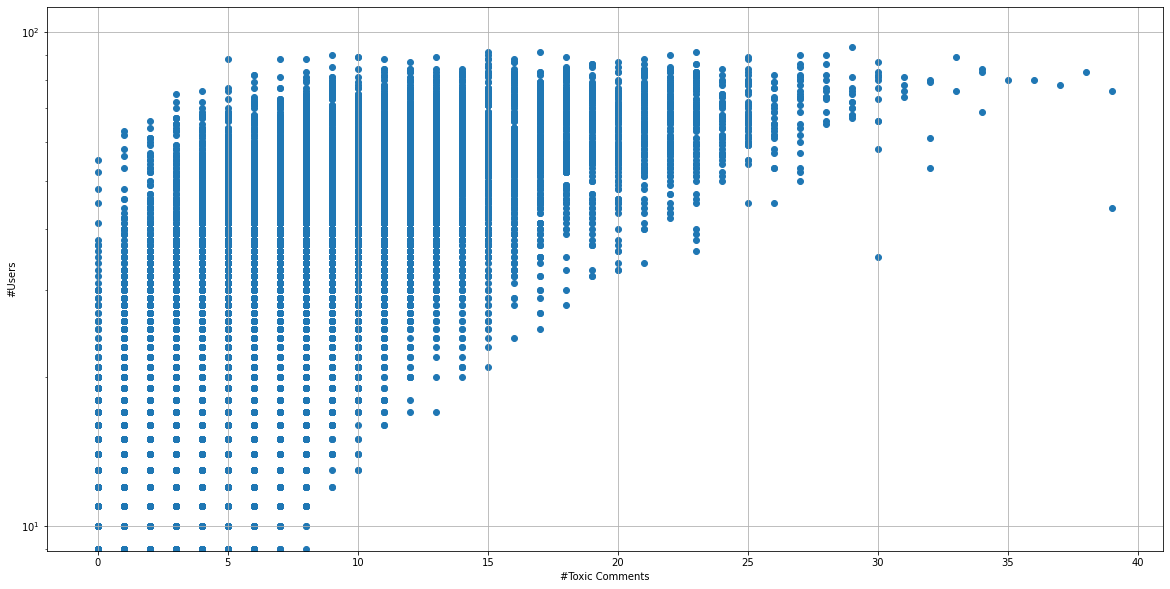

In [ ]:
fig = plt.figure(figsize=(20, 10))
plt.grid()
plt.yscale('log')
plt.scatter(x=num_toxic, y=num_comments) 
plt.ylabel('#Users')
plt.xlabel('#Toxic Comments')

In [ ]:
import statistics
avg_comments = {}
for value in dy:
  if not dy[value] in avg_comments:
    avg_comments[dy[value]] = []
  avg_comments[dy[value]].append(dxu[value])
for value in avg_comments:
  avg_comments[value] = statistics.mean(avg_comments[value])

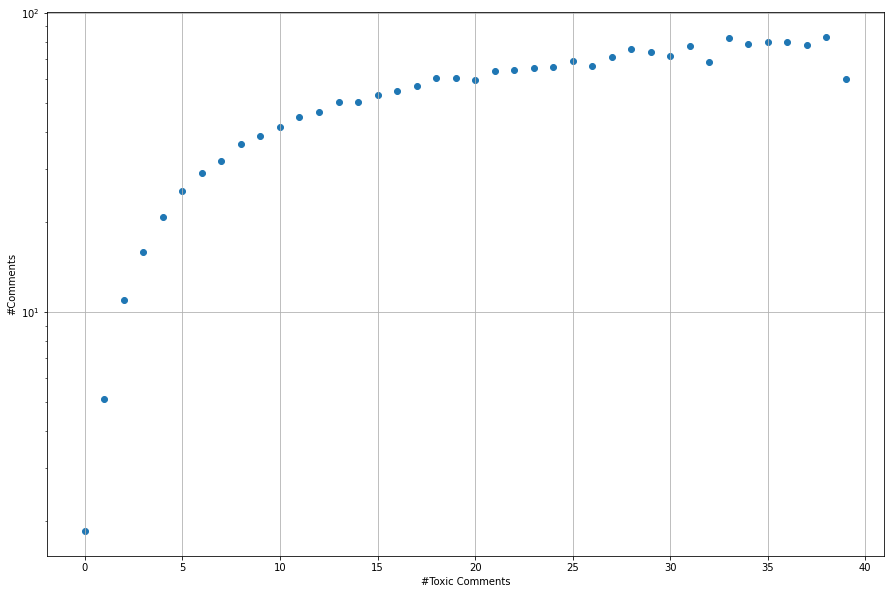

In [ ]:
fig = plt.figure(figsize=(15, 10))
plt.grid()
plt.yscale('log')
plt.scatter(x=avg_comments.keys(), y=avg_comments.values()) 
plt.ylabel('#Comments')
plt.xlabel('#Toxic Comments')

In [ ]:
activation_counter = {}

def count_activation(t3):
  counter = {}
  for user in t3_components[t3]:
    for t2 in t3_map[t3]["comments"]:
      if t3_map[t3]["comments"][t2]["author"]["id"] == user:
        if not t2 in counter:
          counter[t2] = 0
        counter[t2] += 1
  return counter

In [ ]:
t3_activation = {}
for t3 in tqdm(t3_list):
  t3_activation[t3] = count_activation(t3)

100%|██████████| 38706/38706 [00:06<00:00, 5734.18it/s]


In [ ]:
t3_back_onpost = {}
for t3 in t3_activation:
  if not t3 in t3_back_onpost:
    t3_back_onpost[t3] = 0
  for val in t3_activation[t3]:
    if t3_activation[t3][val] > 1:
      t3_back_onpost[t3] += 1

In [ ]:
dxb = collections.OrderedDict(sorted(t3_back_onpost.items()))
num_back = [dxb[val] for val in dxb]

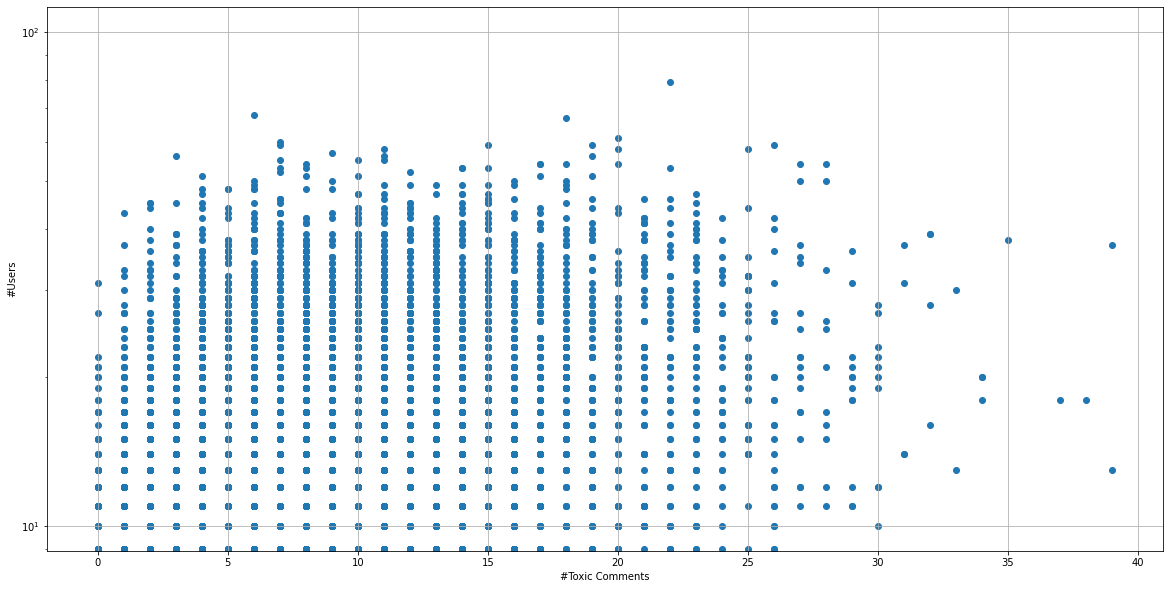

In [ ]:
fig = plt.figure(figsize=(20, 10))
plt.grid()
plt.yscale('log')
plt.scatter(x=num_toxic, y=num_back) 
plt.ylabel('#Users')
plt.xlabel('#Toxic Comments')

In [ ]:
import statistics
avg_back = {}
for value in dy:
  if not dy[value] in avg_back:
    avg_back[dy[value]] = []
  avg_back[dy[value]].append(dxb[value])
for value in avg_back:
  avg_back[value] = statistics.mean(avg_back[value])

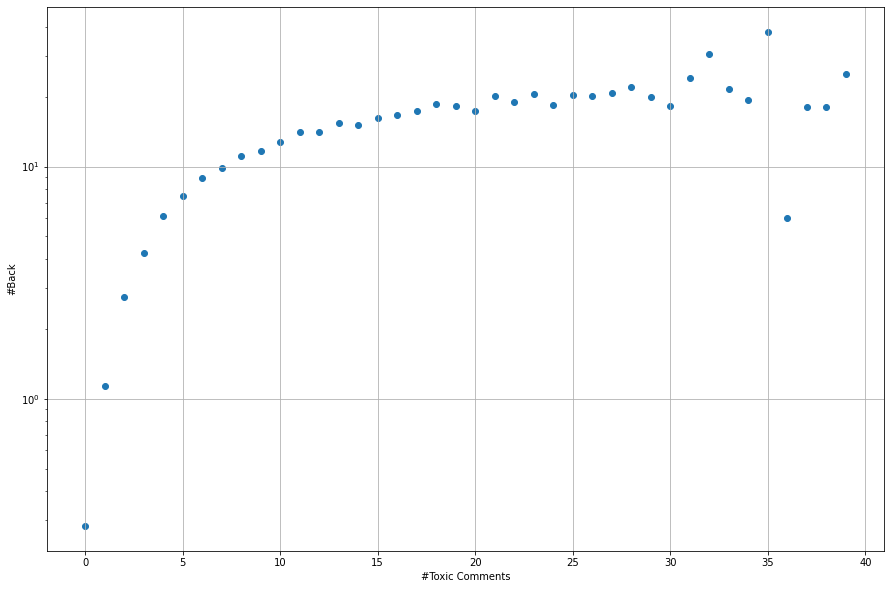

In [ ]:
fig = plt.figure(figsize=(15, 10))
plt.grid()
plt.yscale('log')
plt.scatter(x=avg_back.keys(), y=avg_back.values()) 
plt.ylabel('#Back')
plt.xlabel('#Toxic Comments')

In [ ]:
import ast
num_toxic_comment = 0
num_toxic_active = 0
for (u, v) in tqdm(G.edges()):
    comments = ast.literal_eval(G.edges[u, v]["comments"])
    for t1 in comments.keys():
      comment = comments[t1]
      if 'labels' in comment:
        if float(comment['labels']['political_leaning']['pol_score']) > 0.5:
          num_toxic_comment += 1
          if (v, u) in G.edges():
            comments_reply = ast.literal_eval(G.edges[v, u]["comments"])
            for t1_reply in comments_reply:
              if comments_reply[t1_reply]['parent_id'] == t1:
                num_toxic_active += 1

100%|██████████| 505118/505118 [02:04<00:00, 4060.28it/s]


In [ ]:
print(num_toxic_active / num_toxic_comment)

0.0954107640746895


In [ ]:
left_pol = {
    
}
right_pol = {
    
}
for t3 in tqdm(t3_list):
  posts = ast.literal_eval(G.nodes[t3_map[t3]["author"]["id"]]['submissions'])
  if float(posts[t3]['labels']['political_leaning']['pol_score']) < 0.5:
    left_pol[t3] = []
  else:
    right_pol[t3] = []
  for t1 in t3_map[t3]["comments"]:
    t1_replyto = t3_map[t3]["comments"][t1]["parent_id"]
    if t1_replyto in t3_map[t3]["comments"]:
      t1_replyto = t3_map[t3]["comments"][t1_replyto]["author"]["id"]
    else:
      t1_replyto = t3_map[t3]["author"]["id"]
    t1_author = t3_map[t3]["comments"][t1]["author"]["id"]
    if (t1_author, t1_replyto) in G.edges():
      comments = ast.literal_eval(G.edges[t1_author, t1_replyto]["comments"])
      if t1 in comments:
        if 'labels' in comments[t1]:
          score = float(comments[t1]['labels']['political_leaning']['pol_score'])
          if float(posts[t3]['labels']['political_leaning']['pol_score']) < 0.5:
            left_pol[t3].append(score)
          else:
            right_pol[t3].append(score)

100%|██████████| 38706/38706 [14:24<00:00, 44.76it/s]


In [ ]:
print(len(right_pol))
print(len(left_pol))

13105
25601


In [ ]:
print(len(t3_list))

38706


In [ ]:
import statistics
t3_right_pol = 0
t3_right_pol_toxic = []
t3_left_pol_toxic = []
t3_left_toxic = []
t3_right_toxic = []
for t3 in right_pol:
  if(len(right_pol[t3]) > 0):
    if statistics.mean(right_pol[t3]) > 0.5:
      t3_right_toxic.append(dy[t3]/len(dx[t3]))
      t3_right_pol+=1
    if statistics.mean(right_pol[t3]) < 0.5:
      t3_right_pol_toxic.append(dy[t3]/len(dx[t3]))
t3_left_pol = 0
for t3 in left_pol:
  if(len(left_pol[t3]) > 0):
    if statistics.mean(left_pol[t3]) <= 0.5:
      t3_left_toxic.append(dy[t3]/len(dx[t3]))
      t3_left_pol+=1
    if statistics.mean(left_pol[t3]) > 0.5:
      t3_left_pol_toxic.append(dy[t3]/len(dx[t3]))
print(t3_right_pol)
print(t3_left_pol)

1691
22765


In [ ]:
print(statistics.mean(t3_right_pol_toxic))
print(statistics.mean(t3_right_toxic))
print(statistics.mean(t3_left_pol_toxic))
print(statistics.mean(t3_left_toxic))


0.19804881225817209
0.5128846494634272
0.5107565797511429
0.16603241388850531


In [ ]:
print(t3_right_pol/len(right_pol))

0.12903471957268217


In [ ]:
print(t3_left_pol/len(left_pol))

0.889223077223546


In [ ]:
import ast
t_num_comment = 0
t_num_comment_active = 0
for (u, v) in tqdm(G.edges()):
    comments = ast.literal_eval(G.edges[u, v]["comments"])
    for t1 in comments.keys():
      comment = comments[t1]
      if 'labels' in comment:
        t_num_comment += 1
        if (v, u) in G.edges():
          comments_reply = ast.literal_eval(G.edges[v, u]["comments"])
          for t1_reply in comments_reply:
            if comments_reply[t1_reply]['parent_id'] == t1:
              t_num_comment_active += 1

100%|██████████| 505118/505118 [02:50<00:00, 2968.76it/s]


In [ ]:
print(t_num_comment)

586785


In [ ]:
print(t_num_comment_active)

73238


In [ ]:
print(t_num_comment_active/t_num_comment)

0.12481232478676176
